# User statistics

- `eigen_central` - the user's eigenvector centrality on the aggrigate network (all years)
- `eigen_central_bin` - True if eigen_central is 1 stddev above the mean
- `avg_perplexity` - the mean perplexity of all the user's utterances (based on the aggigate (all years) LM
- `n_utts` - total number of uttrances by the user in the corpus
- `admin status` - the user's admin status (at time of corpus collection)

**Questions:** 

1. What effect does social power have on utterance perplexity? Do users with a high degree of social power (adminship, centrality) speak more or less typcially than those with low social power?
2. Is that effect independent of the fact that users with high social power tend to speak more than those with low social power (and so have a greater effect on what is considered typcial)?

In [31]:
d = read.csv("../data/user_stats.csv", header = TRUE)
library(lsr)
head(d)

user_id,eigen_central,eigen_central_bin,avg_perplexity,n_utts,admin_status
Callcentermonkey,0.0001794088,False,934.2034,1,False
Lilaac,0.0002096814,False,610.2390,2,False
IceCreamAntisocial,0.0015041252,False,44880.5927,6,False
Waygugin,0.0012780205,False,160.8186,1,False
Garyvdm,0.0004765608,False,59.3016,2,False
Nanobear,0.0031741023,False,4016.5541,27,False


In [32]:
# Split the data into admin/non-admin
d.admin <- subset(d, admin_status == "True")
d.nonadmin <- subset(d, admin_status == "False")

# Sanity check: Test for differences in eigenvector centrality for admin/non-admin
t.test(d.admin$eigen_central, d.nonadmin$eigen_central)


	Welch Two Sample t-test

data:  d.admin$eigen_central and d.nonadmin$eigen_central
t = 26.739, df = 1833.4, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.008564153 0.009919943
sample estimates:
  mean of x   mean of y 
0.010561229 0.001319182 


**Result:** As expected admins tend to be more central than non-admins (p < 0.01)

## Social power <> perplexity

In [41]:
t.test(d.admin$avg_perplexity, d.nonadmin$avg_perplexity)
print(cat("Cohen's D:", cohensD(d.admin$avg_perplexity, d.nonadmin$avg_perplexity)))


	Welch Two Sample t-test

data:  d.admin$avg_perplexity and d.nonadmin$avg_perplexity
t = 3.5704, df = 2716, p-value = 0.0003626
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1407.837 4837.970
sample estimates:
mean of x mean of y 
 16655.45  13532.55 


Cohen's D: 0.05035177NULL


**Surprising result:** Admins have a higher average perplexity than non-admins

In [42]:
# Split the data into high centrality/low centrality
d.hcentral <- subset(d, eigen_central_bin == "True")
d.lcentral <- subset(d, eigen_central_bin == "False")

# Test for differences in perplexity for high/low centrality
t.test(d.hcentral$avg_perplexity, d.lcentral$avg_perplexity)
print(cat("Cohen's D:", cohensD(d.hcentral$avg_perplexity, d.lcentral$avg_perplexity)))


	Welch Two Sample t-test

data:  d.hcentral$avg_perplexity and d.lcentral$avg_perplexity
t = 5.4603, df = 2473.5, p-value = 5.229e-08
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2930.595 6215.039
sample estimates:
mean of x mean of y 
 18052.07  13479.25 


Cohen's D: 0.073734NULL


**Result:** Likewise, highly central users have a higher perplexity than low-centrality users (p < 0.01). This time with an even higher effect size than adminship. 

## Controling for number of utterances

In [11]:
library(MASS)
library(ppcor)

pcor.test(d$eigen_central, d$avg_perplexity, d$n_utts)

estimate,p.value,statistic,n,gp,Method
0.01469958,0.01012236,2.571781,30606,1,pearson


**Result:** Further confirming the centrality-perplexity relationship, we correlate avegage perplexity with Eigenvector centrality while controling for the number of utterances.

# Utterance statistics
The `utt_stats` table takes time into account better than the user aggegate statistics. It uses a distinct language model and user network for each year (possible improvement is to build a language model and network for each month using data from the surrounding year).

- `perplexity_overall` - the utterance's perplexity under the LM considering the whole corpus
- `perplexity_year` - the utterance's perplexity under the LM built on just that year's posts
- `admin_status` - the admin status of the user _at the time of the utterance_
- `eigen_central` - the user's Eigenvector centrality in the network for the year in which the utterance occured
- `eigen_central_bin` - if the above is > 1 stddev above the mean for the relevant network
- `utt_rank` - the order of this utterance among all the user's posts
- `days_since_first` - number of days after the user's first utterance in the corpus this was posted

**Questions:**

1. Does the positive correlation between a particular utterance's perplexity and social power hold when you consider the user's social power _at the time of utterance_ (as opposed to avegare perplexity over all a user's utterances).
2. How does the perplexity of a user's utterances change over time?
3. Is there a relationship between a user's social power and how "in vogue" a user's speach is

In [4]:
d = read.csv("../data/utt_stats.csv", header = TRUE)
library(lsr)
head(d)

utt_id,timestamp,perplexity_overall,perplexity_year,admin_status,eigen_central,eigen_central_bin,utt_rank,days_since_first,utt_length
287147,2007-03-16T22:12:00,1376.2694,697.7685,True,0.03237486,True,36,490,142
287140,2007-03-04T16:53:00,38340.6516,40099.9372,False,0.02374293,True,16,83,2
287141,2007-03-04T17:32:00,750.8304,424.0806,False,0.02374293,True,17,83,56
287142,2007-03-04T18:07:00,1480.6781,838.8531,False,0.02374293,True,18,83,41
287148,2007-03-16T23:01:00,135209.1003,50269.7057,True,0.03237486,True,37,490,5
287149,2007-03-17T08:44:00,1134.0916,847.2260,True,0.03237486,True,38,491,24


## Social power <> perplexity (time-sensitive analysis)

In [49]:
# Split the data into utterances by high centrality/low centrality users
d.hcentral <- subset(d, eigen_central_bin == "True")
d.lcentral <- subset(d, eigen_central_bin == "False")

# Split the data into admin/non-admin
d.admin <- subset(d, admin_status == "True")
d.nonadmin <- subset(d, admin_status == "False")


In [46]:
# Test for differences in perplexity for high/low centrality utterances
t.test(d.hcentral$perplexity_year, d.lcentral$perplexity_year)
t.test(d.hcentral$perplexity_overall, d.lcentral$perplexity_overall)


	Welch Two Sample t-test

data:  d.hcentral$perplexity_year and d.lcentral$perplexity_year
t = 12.312, df = 273900, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1198.335 1652.122
sample estimates:
mean of x mean of y 
 7573.527  6148.299 



	Welch Two Sample t-test

data:  d.hcentral$perplexity_overall and d.lcentral$perplexity_overall
t = 9.9255, df = 281790, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2634.039 3930.282
sample estimates:
mean of x mean of y 
 18988.77  15706.61 


**Result:** Confirming the user aggrigate result, a users's centrality at the time of utterance is positively correlated with the utterance's perplexity. This holds both for perplexity calculated on the local (that year's) LM as well as the aggrigate (whole corpus) LM.

## Change in perplexity over time

In [47]:
cor.test(d$perplexity_year, d$days_since_first)
cor.test(d$perplexity_overall, d$days_since_first)


	Pearson's product-moment correlation

data:  d$perplexity_year and d$days_since_first
t = -1.9244, df = 375830, p-value = 0.05431
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -6.336070e-03  5.802254e-05
sample estimates:
         cor 
-0.003139056 



	Pearson's product-moment correlation

data:  d$perplexity_overall and d$days_since_first
t = -7.9811, df = 375830, p-value = 1.455e-15
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.016214014 -0.009820942
sample estimates:
        cor 
-0.01301761 


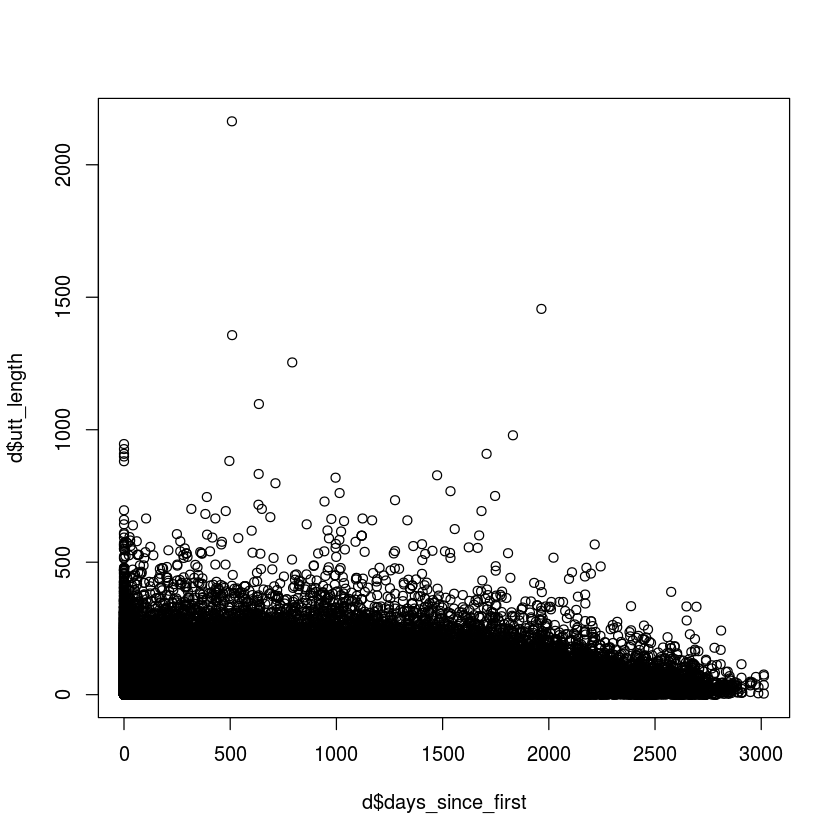

In [5]:
plot(d$days_since_first, d$utt_length)

**Result:** Perplexity (whole corpus LM) is negatively correlated with the number of days since the user's first utterance (suggesting perplexity goes down over time). But the correlation is fairly weak, and not significant for perplexity under the local LM.

## Social power <> trendy speech
Here I'm defining "trendiness" as the difference between perplexity in the overall language model and perplexity in the current (that year's) language model.

In [28]:
# "trendiness" = perplexity_overall - perplexity_year
cor.test(d$perplexity_overall - d$perplexity_year, d$eigen_central)


	Pearson's product-moment correlation

data:  d$perplexity_overall - d$perplexity_year and d$eigen_central
t = 20.284, df = 375830, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.02987464 0.03626180
sample estimates:
       cor 
0.03306855 


In [52]:
t.test(d.hcentral$perplexity_overall - d.hcentral$perplexity_year, d.lcentral$perplexity_overall - d.lcentral$perplexity_year)
print(cat("Cohen's D:", cohensD(d.hcentral$perplexity_overall - d.hcentral$perplexity_year, d.lcentral$perplexity_overall - d.lcentral$perplexity_year)))


	Welch Two Sample t-test

data:  d.hcentral$perplexity_overall - d.hcentral$perplexity_year and d.lcentral$perplexity_overall - d.lcentral$perplexity_year
t = 8.4396, df = 285610, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1425.685 2288.180
sample estimates:
mean of x mean of y 
11415.240  9558.308 


Cohen's D: 0.02886084NULL


**Result:** "Trendiness" is positively correlated with Eigenvector centrality (p < 0.01). Likewise, binarized centrality has a weak but significant positive effect (d = 0.029, p < 0.01) on "trendiness".